In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(69)
dev

'cuda'

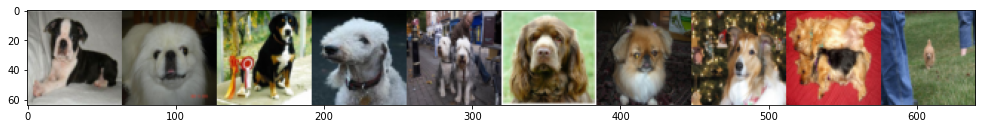

In [2]:
trans = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                            transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
dataset = ImageFolder('./dataset/', transform=trans)
BS = 256
dtld = DataLoader(dataset, batch_size=BS, shuffle=True, drop_last=True)
a = next(iter(dtld))
def implot(imgs, losses=False, save=False):
    imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy()
    img = np.concatenate(imgs, axis=1)
    
    fig, axs = plt.subplots(1 + losses)
    fig.set_size_inches((17, 6))
    if losses:
        axs[0].plot(g_losses, label='Generator losses')
        axs[0].plot(d_losses, label='Discriminator losses')
        axs[1].imshow(img)
    else:
        axs.imshow(img)
    plt.show()
    if save:
        fig.savefig(f'./images/epoch_{epoch}')
implot(a[0][:10])

In [3]:
def load():
    checkpoint = torch.load('checkpoint-spec.pth')
    last_epoch = checkpoint['epoch']
    g.load_state_dict(checkpoint['g_state_dict'])
    d.load_state_dict(checkpoint['d_state_dict'])
    g_optim.load_state_dict(checkpoint['g_optim_state_dict'])
    d_optim.load_state_dict(checkpoint['d_optim_state_dict'])
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']
    
    return last_epoch, g_losses, d_losses

def save():
    torch.save({
                'epoch': epoch,
                 'g_state_dict': g.state_dict(),
                'd_state_dict': d.state_dict(),
                'g_optim_state_dict': g_optim.state_dict(),
                'd_optim_state_dict': d_optim.state_dict(),
                'g_losses': g_losses,
                'd_losses': d_losses,
                }, 'checkpoint-spec.pth')

In [4]:
class PrintShape(nn.Module):
    def __init__(self):
        super(PrintShape, self).__init__()
    def forward(self, x):
        print(x.shape)
        return x
    
class GaussianNosie(nn.Module):
    def __init__(self):
        super(GaussianNosie, self).__init__()
        self.std = nn.parameter.Parameter(torch.tensor(.1))
    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(0, self.std.data.item())

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.noise = GaussianNosie()

        def block(in_c, out_c, bn=True):
            b = [
                nn.utils.spectral_norm(
                    nn.Conv2d(in_c, out_c, 5, 2, 2, bias=False)),
            ]
            if bn:
                b.append(nn.BatchNorm2d(out_c))
            b.append(nn.LeakyReLU(.2, inplace=True))
            return b

        self.conv = nn.Sequential(
            *block(3, 64, bn=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, bias=False),
            nn.Sigmoid()
        )
        self.flat = nn.Flatten()
    def forward(self, x):
        x = self.noise(x)
        x = self.conv(x)
        return self.flat(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_c, out_c):
            return [
                nn.utils.spectral_norm(
                    nn.ConvTranspose2d(in_c, out_c, 5, 2, 1, bias=False)),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
        self.conv = nn.Sequential(
            *block(100, 512),
            *block(512, 256),
            *block(256, 128),
            *block(128, 64),
            nn.ConvTranspose2d(64, 3, 5, 2, 1, 1, bias=False),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.conv(x.view(-1, 100, 1, 1))

g = Generator().to(dev)
d = Discriminator().to(dev)
g_losses = []
d_losses = []
d(g(torch.randn((BS, 100), device=dev))).shape
# g(torch.randn((BS, 100), device=dev)).shape

torch.Size([256, 1])

In [5]:
def train_test_loop(dtld, train=True):
    for i, (x, _) in enumerate(dtld):
        x = x.to(dev)

        z = torch.randn((BS, 100), device=dev)
        ones, zeros = torch.full([BS], .9, device=dev), torch.zeros((BS), device=dev)
        gen_imgs = g(z)
        
        # Train generator
        for p in g.parameters():
            p.grad = None
        y_hat = d(gen_imgs).reshape((-1))
        g_loss = g_crit(y_hat, ones)
        g_loss.backward()
        g_optim.step()

        # Train discriminator
        for p in d.parameters():
            p.grad = None
        ones_hat, zeros_hat = d(x).reshape((-1)), d(gen_imgs.detach()).reshape((-1))
        d_loss = (d_crit(ones_hat, ones) + d_crit(zeros_hat, zeros)) / 2
        d_loss.backward()
        d_optim.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

  0%|          | 0/299 [00:00<?, ?it/s]

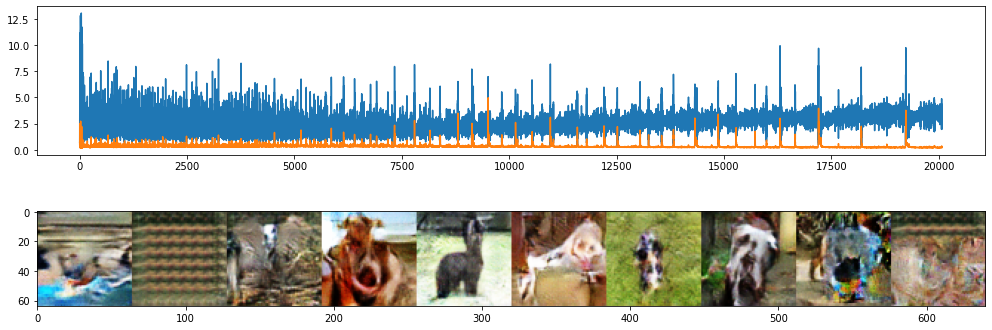

D_losses=0.2324 | G_losses=2.7179:   0%|          | 1/299 [05:08<25:31:30, 308.36s/it]

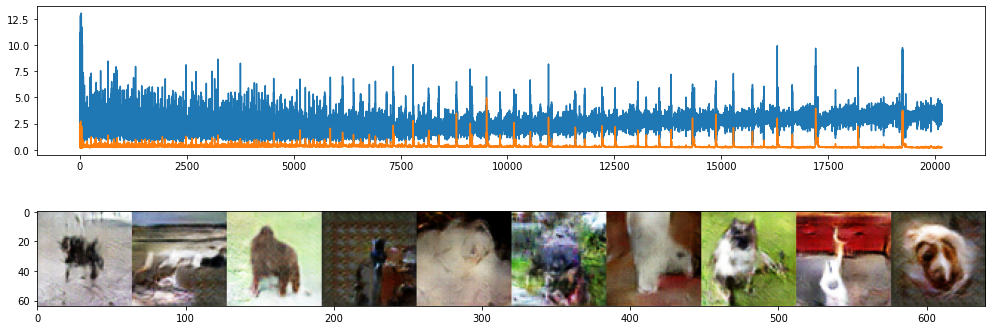

D_losses=0.2118 | G_losses=3.7755:   1%|          | 2/299 [07:36<17:40:45, 214.29s/it]

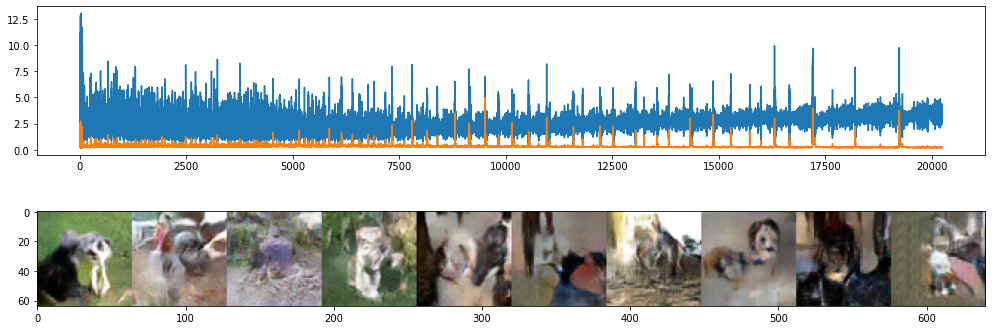

D_losses=0.2064 | G_losses=3.4172:   1%|          | 3/299 [10:04<15:06:24, 183.73s/it]

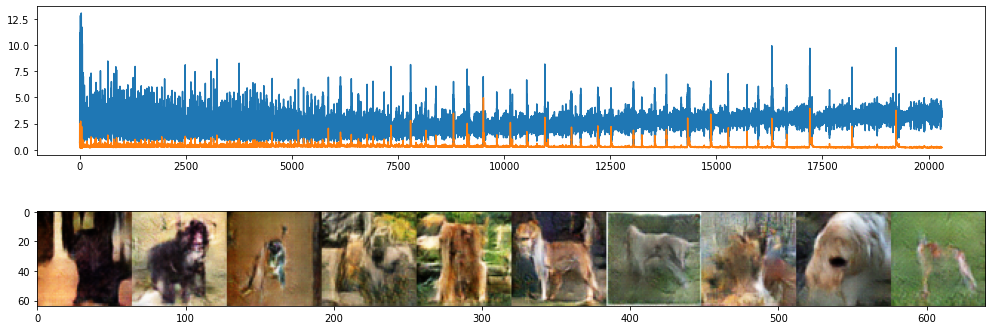

D_losses=0.2020 | G_losses=4.0042:   1%|▏         | 4/299 [12:31<13:53:17, 169.48s/it]

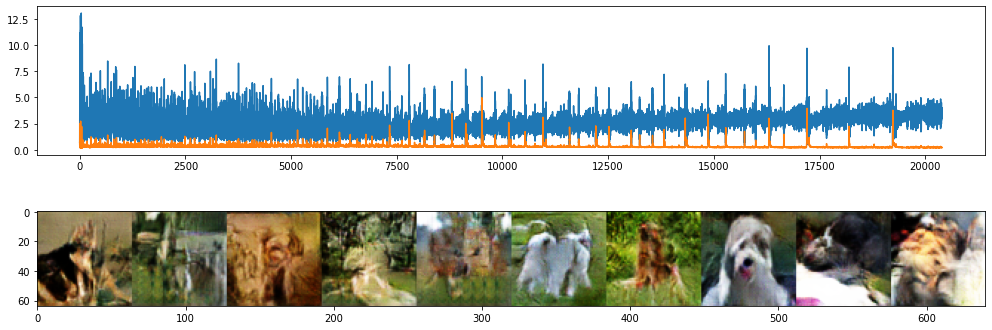

D_losses=0.2846 | G_losses=2.4127:   2%|▏         | 5/299 [14:58<13:09:18, 161.08s/it]

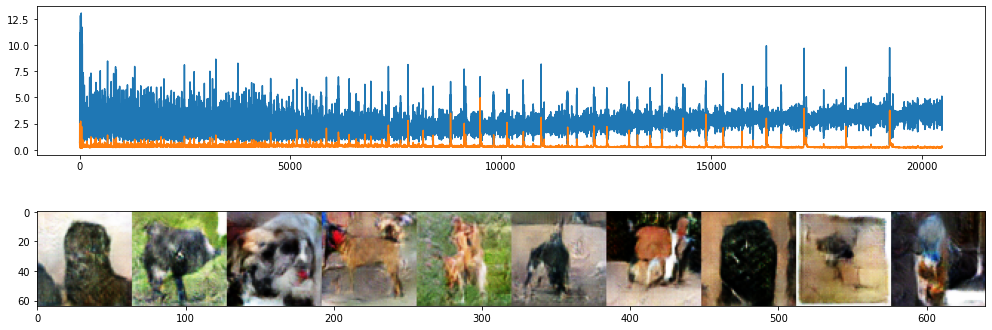

D_losses=0.1998 | G_losses=3.6125:   2%|▏         | 6/299 [17:23<12:40:15, 155.68s/it]

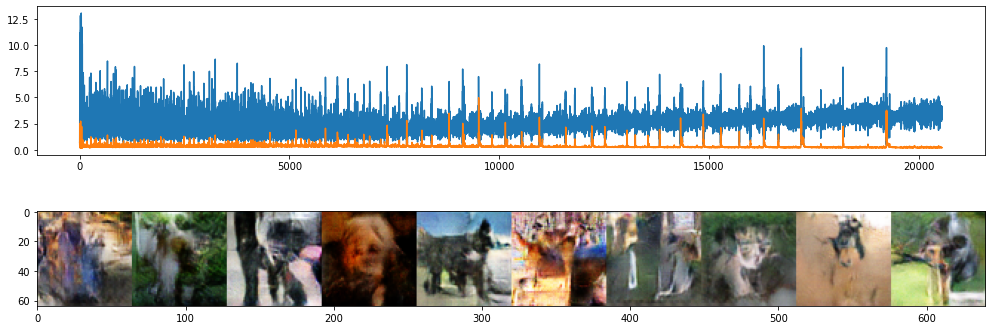

D_losses=0.6719 | G_losses=1.3970:   2%|▏         | 7/299 [19:48<12:21:35, 152.38s/it]

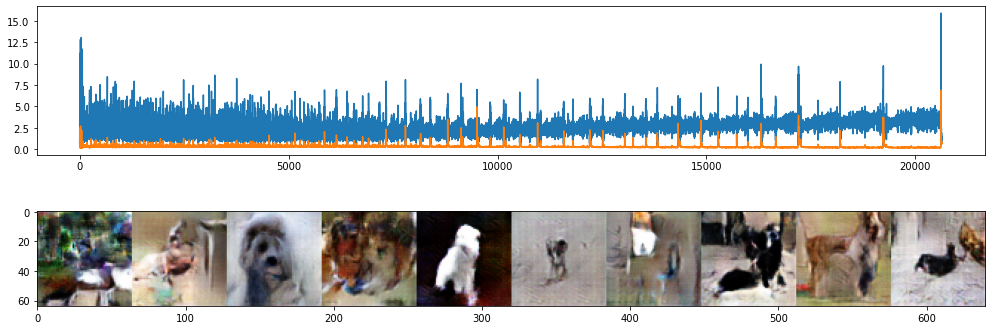

D_losses=0.4660 | G_losses=1.6294:   3%|▎         | 8/299 [22:16<12:11:06, 150.75s/it]

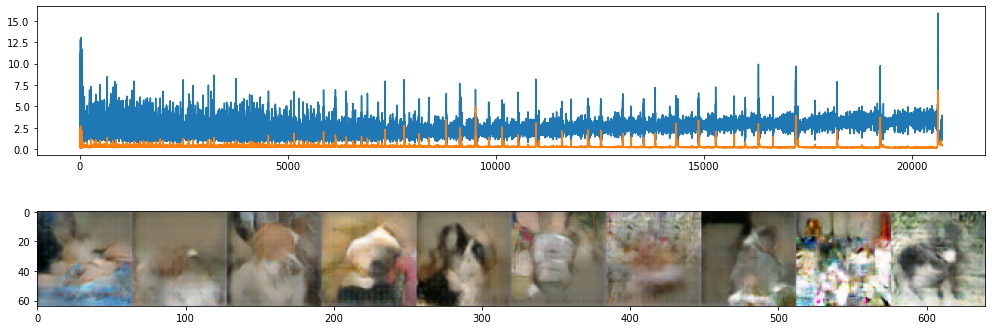

D_losses=0.2696 | G_losses=3.0183:   3%|▎         | 9/299 [24:42<12:01:32, 149.28s/it]

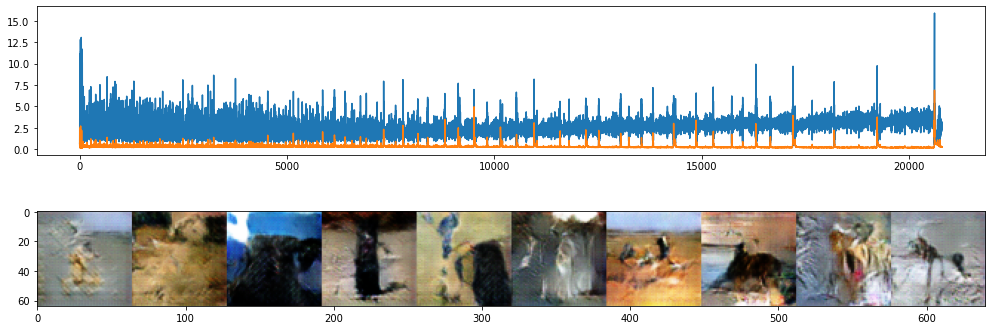

D_losses=0.2272 | G_losses=2.8444:   3%|▎         | 10/299 [27:11<11:59:20, 149.34s/it]

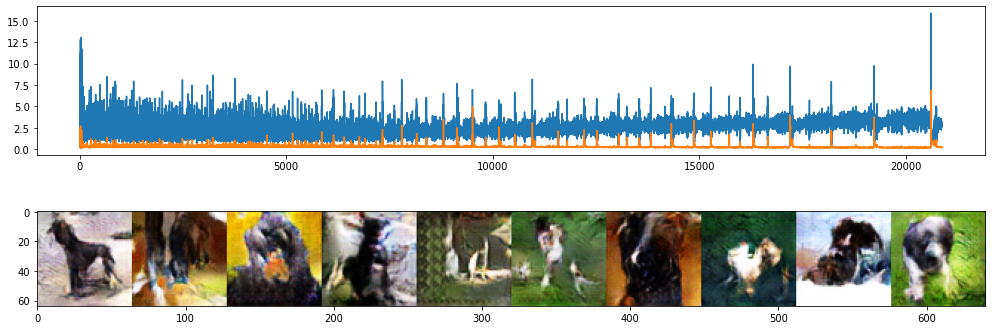

D_losses=0.2138 | G_losses=3.3020:   4%|▎         | 11/299 [29:43<12:00:33, 150.12s/it]

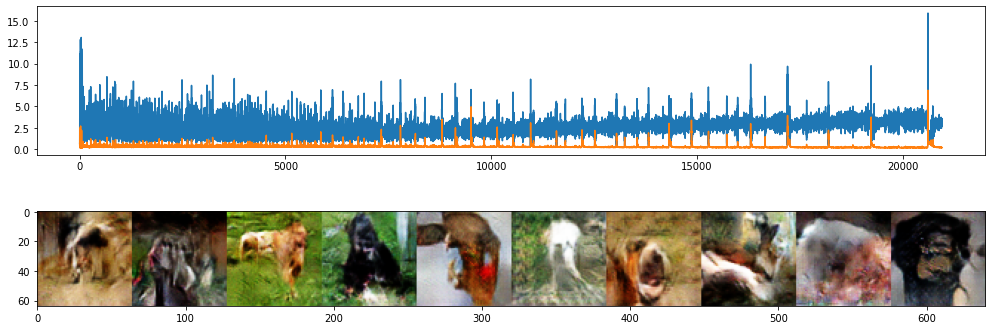

D_losses=0.2121 | G_losses=3.4472:   4%|▍         | 12/299 [32:14<11:59:17, 150.38s/it]

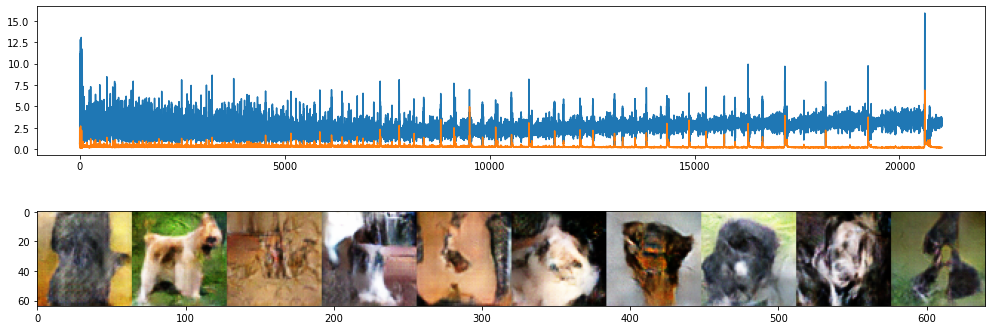

D_losses=0.2152 | G_losses=3.0790:   4%|▍         | 13/299 [34:46<11:59:12, 150.88s/it]

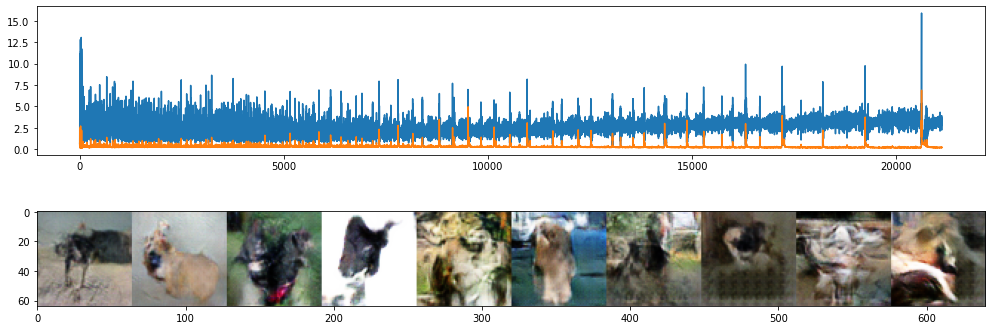

D_losses=0.2205 | G_losses=2.9807:   5%|▍         | 14/299 [37:16<11:56:01, 150.74s/it]

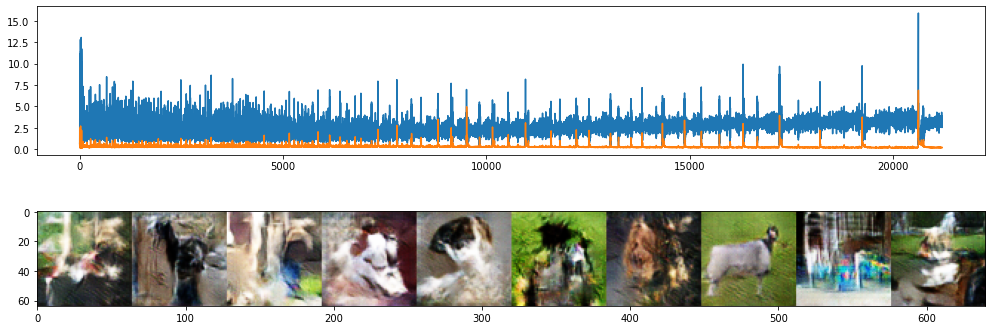

D_losses=0.2322 | G_losses=2.6591:   5%|▌         | 15/299 [39:46<11:52:09, 150.46s/it]

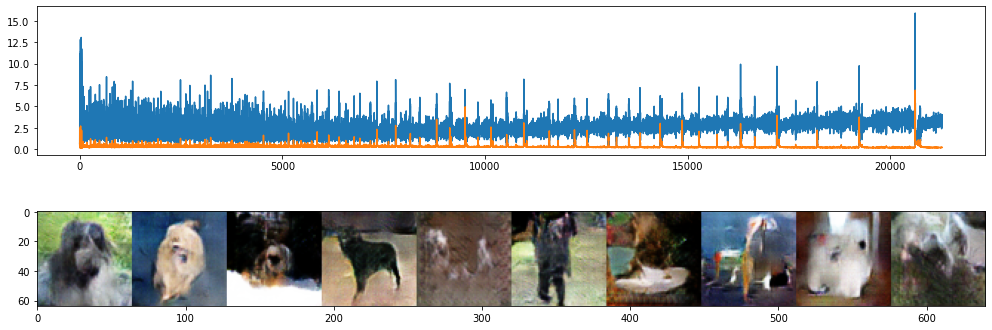

D_losses=0.2197 | G_losses=3.5633:   5%|▌         | 16/299 [42:15<11:47:15, 149.95s/it]

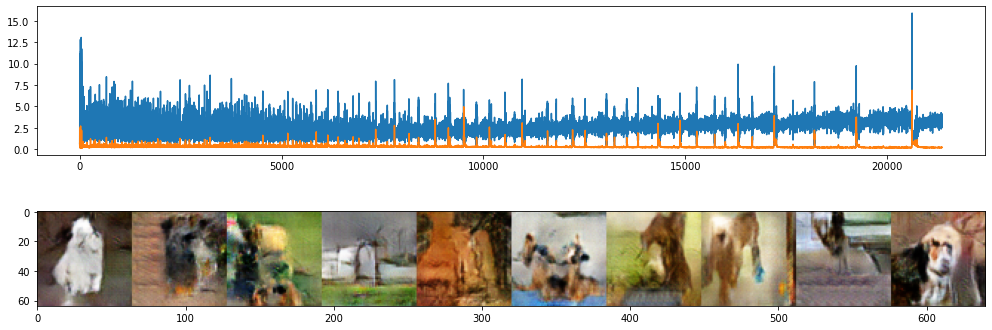

D_losses=0.2564 | G_losses=4.2466:   6%|▌         | 17/299 [44:41<11:39:05, 148.74s/it]

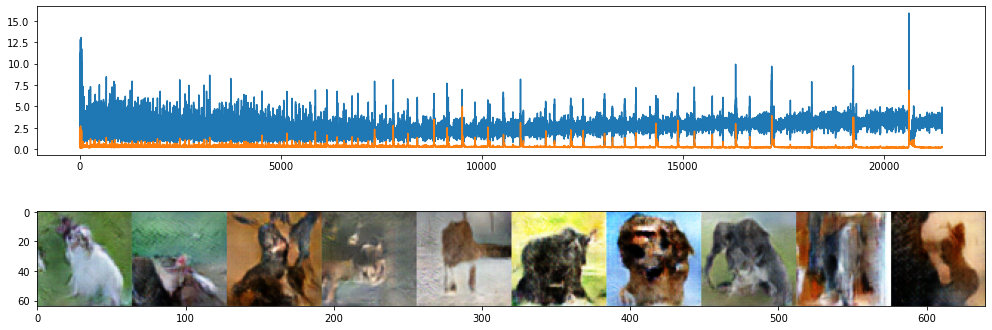

D_losses=0.3035 | G_losses=4.6800:   6%|▌         | 18/299 [47:07<11:32:31, 147.87s/it]

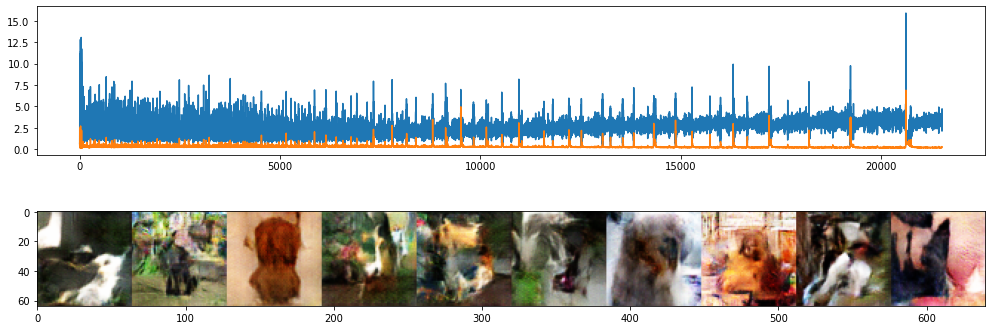

D_losses=0.2011 | G_losses=3.5347:   6%|▋         | 19/299 [49:33<11:28:20, 147.50s/it]

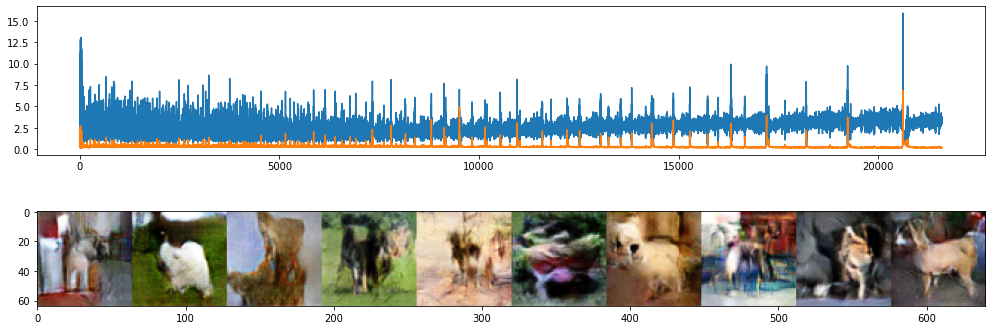

D_losses=0.1986 | G_losses=3.6242:   7%|▋         | 20/299 [52:03<11:28:14, 148.01s/it]

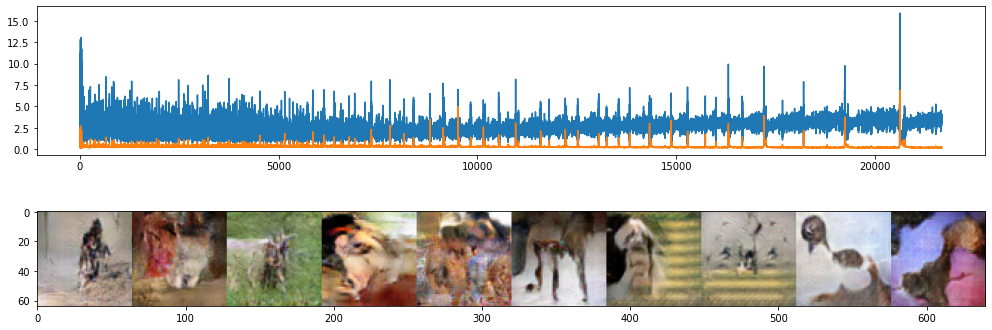

D_losses=0.2251 | G_losses=2.6973:   7%|▋         | 21/299 [54:30<11:24:56, 147.83s/it]

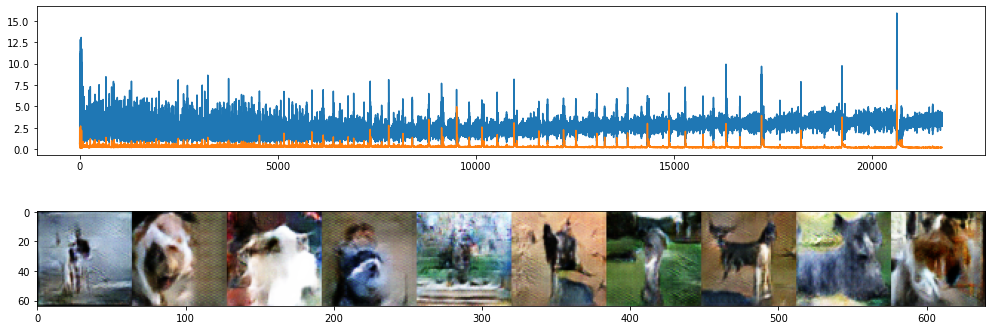

D_losses=0.2027 | G_losses=3.4894:   7%|▋         | 22/299 [56:58<11:22:51, 147.91s/it]

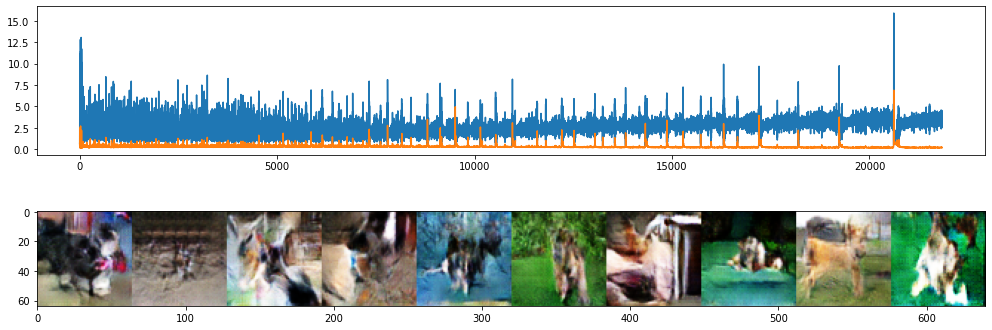

D_losses=1.5292 | G_losses=4.1742:   8%|▊         | 23/299 [59:26<11:20:31, 147.94s/it]

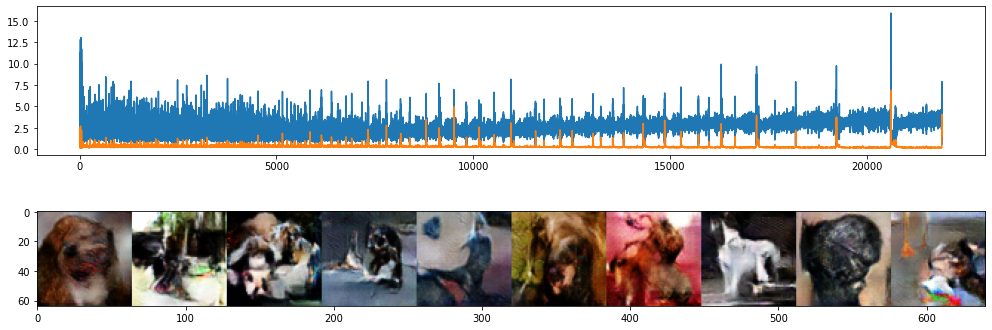

D_losses=0.2374 | G_losses=2.7059:   8%|▊         | 24/299 [1:01:53<11:16:49, 147.67s/it]

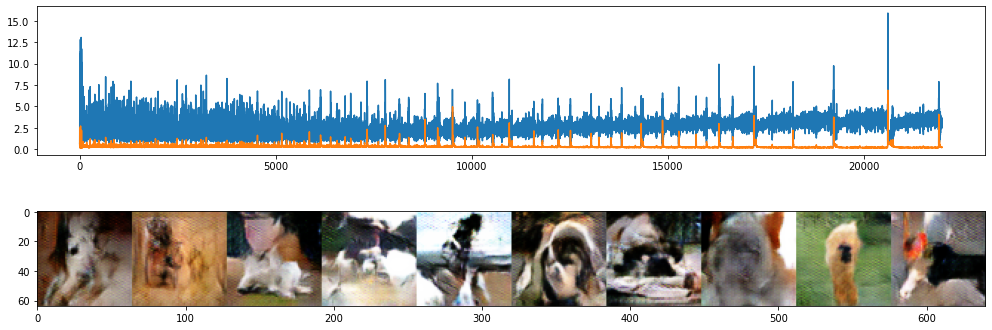

D_losses=0.2343 | G_losses=2.7454:   8%|▊         | 25/299 [1:04:21<11:14:37, 147.73s/it]

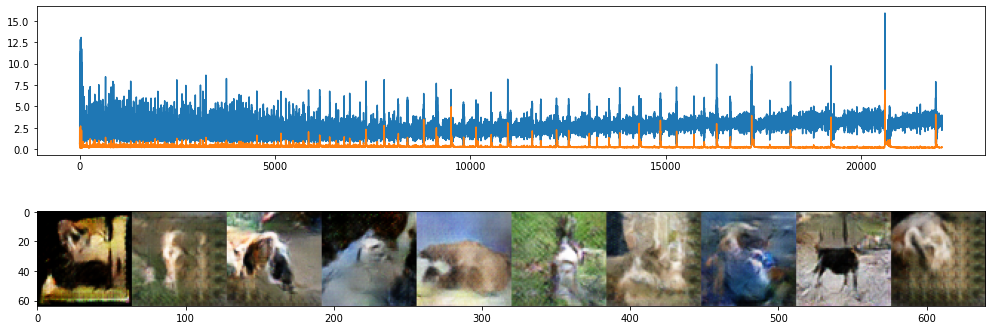

D_losses=0.2317 | G_losses=4.1453:   9%|▊         | 26/299 [1:06:49<11:12:23, 147.78s/it]

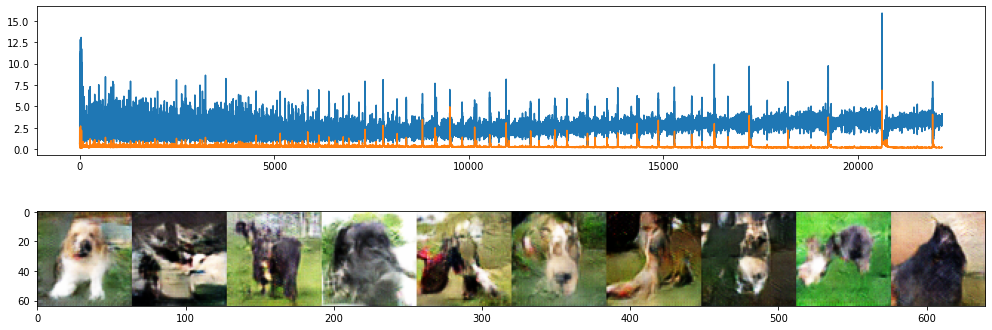

D_losses=0.1956 | G_losses=3.6082:   9%|▉         | 27/299 [1:09:16<11:09:38, 147.72s/it]

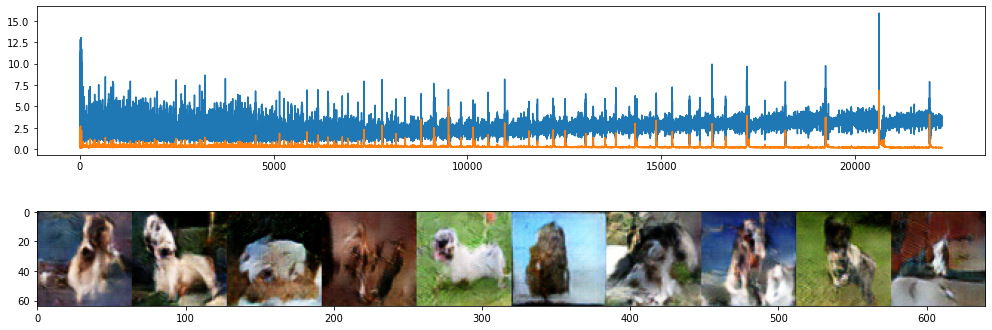

D_losses=0.1982 | G_losses=3.7250:   9%|▉         | 28/299 [1:11:46<11:10:06, 148.36s/it]

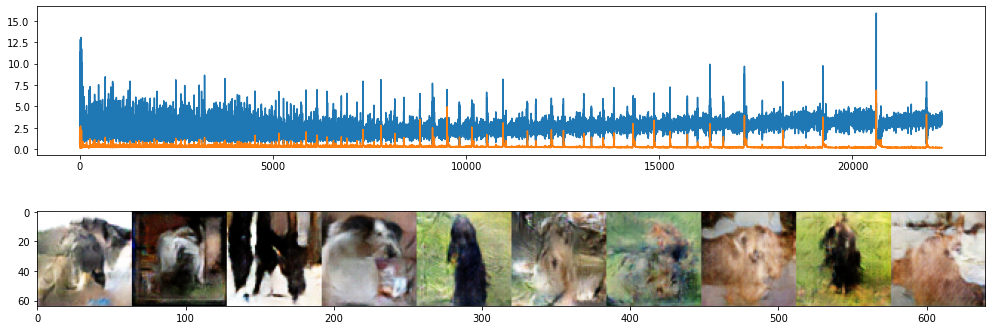

D_losses=0.2068 | G_losses=3.4475:  10%|▉         | 29/299 [1:14:14<11:06:29, 148.11s/it]

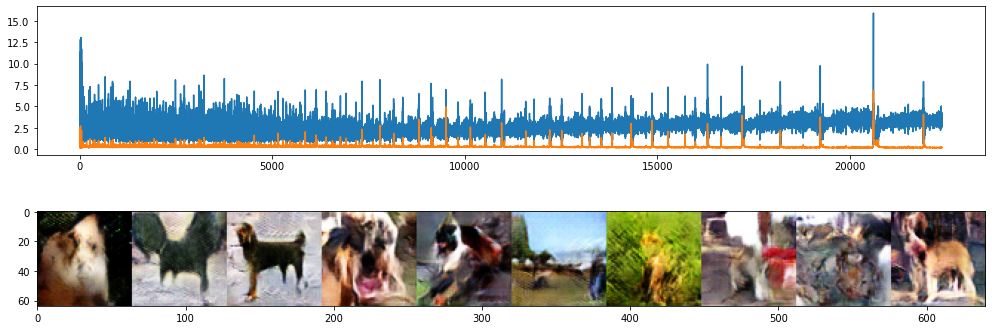

D_losses=0.2220 | G_losses=3.4511:  10%|█         | 30/299 [1:16:39<10:59:36, 147.12s/it]

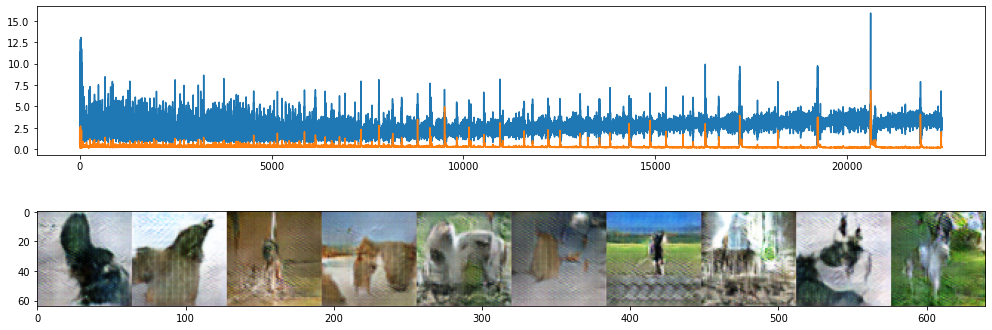

D_losses=0.1993 | G_losses=3.8556:  10%|█         | 31/299 [1:19:04<10:55:04, 146.66s/it]

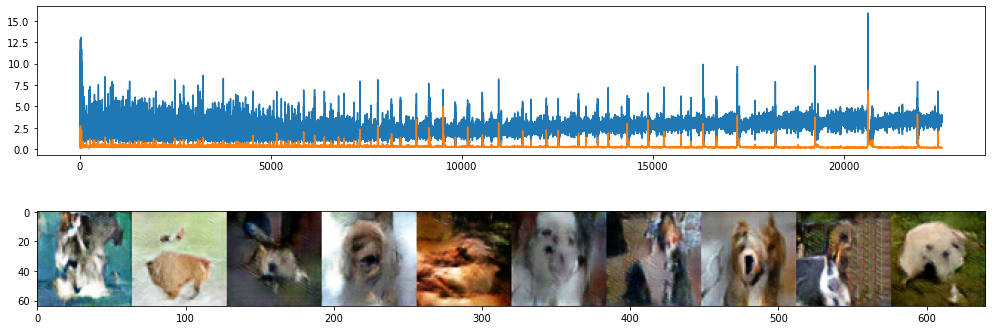

In [ ]:
g_crit = nn.BCELoss()
d_crit = nn.BCELoss()
g_optim = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(.5, .999))
d_optim = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(.5, .999))
last_epoch, g_losses, d_losses = load()
epochs = last_epoch + 300

for epoch in (t := trange(last_epoch + 1, epochs)):
    implot(g(torch.randn((BS, 100), device=dev))[:10], losses=True, save=True)
    save()
    train_test_loop(dtld)
    t.set_description(f'D_losses=%.4f | G_losses=%.4f' % (d_losses[-1], g_losses[-1]))

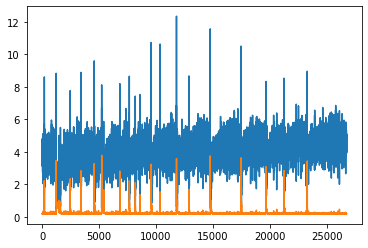

In [ ]:
plt.plot(g_losses, label='Generator losses')
plt.plot(d_losses, label='Discriminator losses')
plt.show()

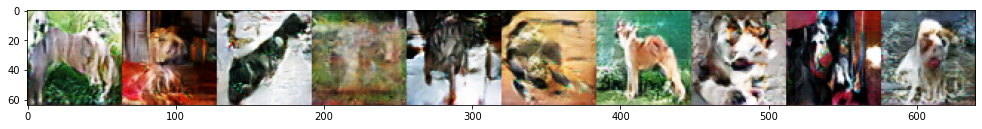

In [ ]:
implot(g(torch.randn((BS, 100), device=dev)[:10]))